## Part-1: KNN Classifier

## Task-1: Displaying data visually

In [1]:
import  time
import  heapq
import  numpy                     as      np
import  pandas                    as      pd
import  matplotlib.pyplot         as      plt
from    itertools                 import  chain, combinations
from    sklearn.tree              import  DecisionTreeClassifier
from    sklearn.utils             import  shuffle
from    sklearn.metrics           import  accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from    sklearn.neighbors         import  KNeighborsClassifier
from    sklearn.model_selection   import  train_test_split, KFold

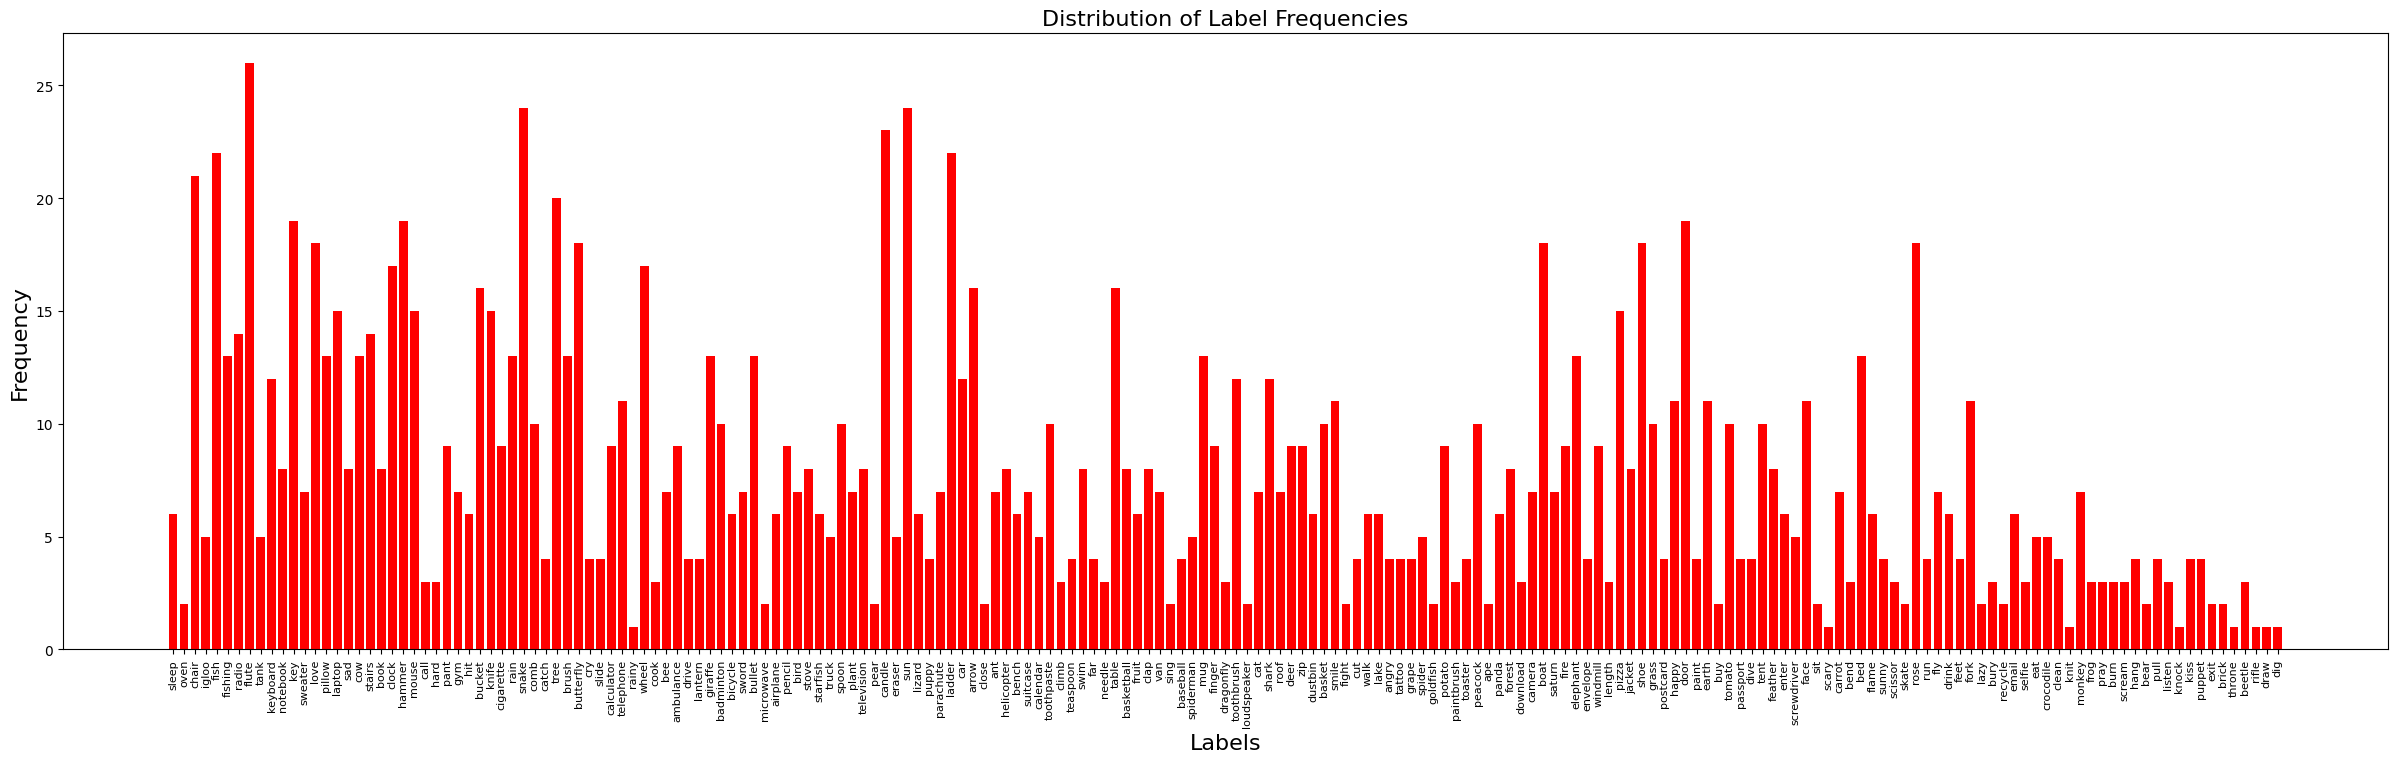

In [2]:
# Read the .npy file
data = np.load('./data.npy', allow_pickle=True)

# Extract labels from data
labels = [example[3] for example in data]

# Calculate label counts
labels_count = {}
for label in labels:
  if label in labels_count:
    labels_count[label] += 1
  else:
    labels_count[label] = 1

# Convert the label counts to two lists: labels and frequencies
labels = list(labels_count.keys())
frequencies = list(labels_count.values())

# print(len(labels))
# 193 distinct labels

plt.figure(figsize=(30, 8))

# Create a bar plot of label frequencies
plt.bar(labels, frequencies, color='red')
plt.xlabel('Labels', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Distribution of Label Frequencies', fontsize=16)
plt.xticks(rotation=90, fontsize=8)
plt.show()

## Task-2: KNN Implementation

In [3]:
class KNNModel:
  def __init__(self):
    self.k = 2
    self.encoder = 'ResNet'
    self.distance_metric = 'euclidean'
    self.X_train = []
    self.Y_train = []
    
  def set_encoder(self, encoder_name):
    encoder = {}
    encoder['name'] = encoder_name
    encoder['X'] = []
    encoder['Y'] = []
    
    if encoder['name'] == 'ResNet':
      for row in data:
        encoder['X'].append(row[1])
        encoder['Y'].append(row[3])
      
    elif encoder['name'] == 'VIT':
      for row in data:
        encoder['X'].append(row[2])
        encoder['Y'].append(row[3])
      
    else:
      raise ValueError('Unknown encoder')
      
    self.encoder = encoder
  
  def set_distance_metric(self, distance_metric):
    self.distance_metric = distance_metric
    
  def set_k(self, k):
    self.k = k
    
  def calculate_distance(self, x1, x2):
    if self.distance_metric == 'euclidean':
      return np.sqrt(np.sum((x1 - x2) ** 2))
    elif self.distance_metric == 'manhattan':
      return np.sum(np.abs(x1 - x2))
    elif self.distance_metric == 'cosine':
      # cosine distance = 1 - cosine similarity
      return 1 - (np.dot(x1.flatten(), x2.flatten()) / (np.linalg.norm(x1) * np.linalg.norm(x2)))
    else:
      raise ValueError('Unknown distance metric')
    
  def fit(self, X_train, Y_train):
    self.X_train = np.array(X_train)
    self.Y_train = np.array(Y_train)
  
  def predict(self, X):
    y_pred = []
    for x in X:
      distances = []
      k_nearest = []
      for i, x_train in enumerate(self.X_train):
        heapq.heappush(distances, (self.calculate_distance(x, x_train), self.Y_train[i]))
      while distances and len(k_nearest) < self.k:
        k_nearest.append(heapq.heappop(distances)[1])
      y_pred.append(max(set(k_nearest), key = k_nearest.count))
    return y_pred
  
  def evaluate(self, X_test, Y_test):
    # predict the test data
    y_pred = self.predict(X_test)
    # calculate the metrics
    accuracy = accuracy_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(Y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(Y_test, y_pred, average='macro', zero_division=0)
    return [accuracy*100, precision*100, recall*100, f1*100]
  
  def get_accuracy(self, X_test, Y_test):
    return self.evaluate(X_test, Y_test)[0]

In [4]:
knn = KNNModel()
knn.set_encoder('ResNet')
knn.set_distance_metric('euclidean')
knn.set_k(13)
X_train, X_test, Y_train, Y_test = train_test_split(knn.encoder['X'], knn.encoder['Y'], test_size=0.2, random_state=0)
knn.fit(X_train, Y_train)
print('accuracy precision recall f1: ', *knn.evaluate(X_test, Y_test))

accuracy precision recall f1:  18.333333333333332 10.950499086595629 12.267573696145122 9.667942808808911


## Task-3: Hyperparameter Tuning

In [5]:
if __name__ == "__main__":
  knn = KNNModel()
  encoders = ['ResNet', 'VIT']
  distance_metrics = ['euclidean', 'manhattan', 'cosine']
  parameters = []
  parameters_vit = []
  for encoder in encoders:
    knn.set_encoder(encoder)
    X_train, X_test, Y_train, Y_test = train_test_split(knn.encoder['X'], knn.encoder['Y'], test_size=0.2, random_state=42)
    knn.fit(X_train, Y_train)
    for k in range(1,41,2):
      for distance_metric in distance_metrics:
        knn.set_k(k)
        knn.set_distance_metric(distance_metric)
        heapq.heappush(parameters, (knn.get_accuracy(X_test,Y_test), knn.k, knn.encoder['name'], knn.distance_metric))
        if encoder == 'VIT':
          heapq.heappush(parameters_vit, (knn.get_accuracy(X_test,Y_test), knn.k, knn.encoder['name'], knn.distance_metric))
    if encoder == 'ResNet':
      print('best validation accuracy triplet for ResNet: ', heapq.nlargest(1, parameters)[0])
  print('best validation accuracy triplet for VIT: ', heapq.nlargest(1, parameters_vit)[0])
  # Print an Ordered rank list of top 20 such triplets.
  top20 = (heapq.nlargest(20, parameters))
  print('top 20 triplets:')
  for triplet in top20:
    print(triplet)
    
  print('--'*20)
  
  # Find the best (k, encoder, distance metric) triplet that 
  # gives the best validation accuracy for a given data split (your choice).
  best_knn_metrics = heapq.nlargest(1, parameters)[0]
  print('best validation accuracy triplet: ', best_knn_metrics)

best validation accuracy triplet for ResNet:  (20.666666666666668, 9, 'ResNet', 'manhattan')
best validation accuracy triplet for VIT:  (27.666666666666668, 1, 'VIT', 'manhattan')
top 20 triplets:
(27.666666666666668, 1, 'VIT', 'manhattan')
(27.0, 1, 'VIT', 'euclidean')
(26.333333333333332, 13, 'VIT', 'manhattan')
(26.0, 23, 'VIT', 'euclidean')
(26.0, 1, 'VIT', 'cosine')
(25.666666666666664, 23, 'VIT', 'manhattan')
(25.333333333333336, 25, 'VIT', 'manhattan')
(25.333333333333336, 19, 'VIT', 'manhattan')
(25.0, 25, 'VIT', 'euclidean')
(25.0, 25, 'VIT', 'cosine')
(25.0, 21, 'VIT', 'manhattan')
(24.666666666666668, 27, 'VIT', 'cosine')
(24.666666666666668, 23, 'VIT', 'cosine')
(24.666666666666668, 21, 'VIT', 'euclidean')
(24.666666666666668, 11, 'VIT', 'manhattan')
(24.333333333333336, 31, 'VIT', 'cosine')
(24.333333333333336, 29, 'VIT', 'manhattan')
(24.333333333333336, 29, 'VIT', 'euclidean')
(24.333333333333336, 27, 'VIT', 'manhattan')
(24.333333333333336, 17, 'VIT', 'manhattan')
-----

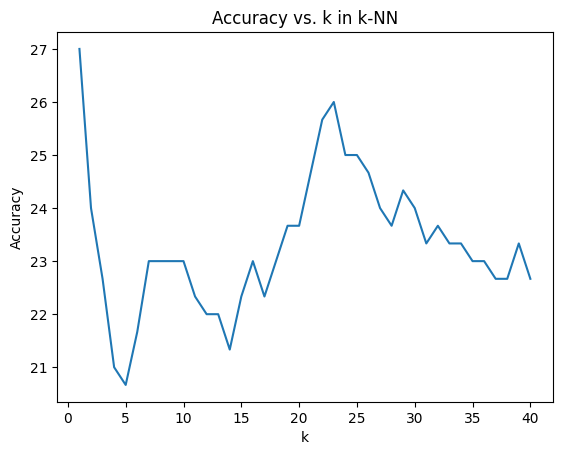

In [6]:
# Plot k vs accuracy given a choice(yours) of any given distance, encoder pair (with a constant data split).
# distance metric = euclidean, encoder = VIT
knn = KNNModel()
knn.set_encoder('VIT')
knn.set_distance_metric('euclidean')
X_train, X_test, Y_train, Y_test = train_test_split(knn.encoder['X'], knn.encoder['Y'], test_size=0.2, random_state=42)
knn.fit(X_train, Y_train)
accuracy = []
for k in range(1,41):
  knn.set_k(k)
  accuracy.append(knn.get_accuracy(X_test, Y_test))
plt.plot(range(1,41), accuracy)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k in k-NN')
plt.show()

## Task-5: Optimisation

#### chatgpt help

In [7]:
class Optimised_KNNModel(KNNModel):
  def calculate_distance(self, x1, x2):
    if self.distance_metric == 'euclidean':
      return np.sqrt(np.sum((x1 - x2) ** 2, axis=-1))
    elif self.distance_metric == 'manhattan':
      return np.sum(np.abs(x1 - x2), axis=-1)
    elif self.distance_metric == 'cosine':
      dot_product = np.sum(x1 * x2, axis=-1)
      norms_product = np.linalg.norm(x1, axis=-1) * np.linalg.norm(x2, axis=-1)
      return 1 - (dot_product / norms_product)
    else:
        raise ValueError('Unknown distance metric')
      
  def predict(self, X):
    y_pred = []
    for x in X:
      distances = self.calculate_distance(self.X_train, x).flatten()
      k_nearest = self.Y_train[np.argpartition(distances, self.k)[:self.k]]
      unique_labels, label_counts = np.unique(k_nearest, return_counts=True)
      max_count_index = np.argmax(label_counts)
      y_pred.append(unique_labels[max_count_index])
    return y_pred


#### Optimised KNN model

In [8]:
start_time = time.time()

knn = Optimised_KNNModel()
knn.set_k(5)
knn.set_encoder('ResNet')
knn.set_distance_metric('euclidean')
X_train, X_test, Y_train, Y_test = train_test_split(knn.encoder['X'], knn.encoder['Y'], test_size=0.2, random_state=42)
knn.fit(X_train, Y_train)
metrics = knn.evaluate(X_test, Y_test)

elapsed_time_optimal = time.time() - start_time

print("Accuracy:", metrics[0])
print("Precision:", metrics[1])
print("Recall:", metrics[2])
print("F1 Score:", metrics[3])

Accuracy: 16.666666666666664
Precision: 9.215379990379992
Recall: 9.93015873015873
F1 Score: 8.363290058181699


#### Default sklearn KNN model

In [9]:
start_time = time.time()

# triplet considered = best triplet
# k = 5, encoder = ResNet, distance metric = default knn metric
X = []
Y = []
for row in data:
  X.append(row[1].flatten())
  Y.append(row[3])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Create and train KNN classifier
k = 5  # Number of neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = knn_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

elapsed_time_default = time.time() - start_time

print("Accuracy:", accuracy*100)
print("Precision:", precision*100)
print("Recall:", recall*100)
print("F1 Score:", f1*100)


Accuracy: 17.666666666666668
Precision: 11.781640912435615
Recall: 12.298959318826867
F1 Score: 10.374941467656699


#### Initial KNN model

In [10]:
start_time = time.time()

knn = KNNModel()
knn.set_k(5)
knn.set_encoder('ResNet')
knn.set_distance_metric('euclidean')
X_train, X_test, y_train, y_test = train_test_split(knn.encoder['X'], knn.encoder['Y'], test_size=0.2, random_state=42)
knn.fit(X_train, y_train)
metrics = knn.evaluate(X_test, y_test)

elapsed_time_initial = time.time() - start_time

print("Accuracy:", metrics[0])
print("Precision:", metrics[1])
print("Recall:", metrics[2])
print("F1 Score:", metrics[3])


Accuracy: 17.333333333333336
Precision: 10.406953456701112
Recall: 10.909980430528377
F1 Score: 9.621328398524206


#### Best KNN model

In [11]:
start_time = time.time()

knn = KNNModel()
knn.set_k(best_knn_metrics[1])
knn.set_encoder(best_knn_metrics[2])
knn.set_distance_metric(best_knn_metrics[3])
X_train, X_test, y_train, y_test = train_test_split(knn.encoder['X'], knn.encoder['Y'], test_size=0.2, random_state=42)
knn.fit(X_train, y_train)
metrics = knn.evaluate(X_test, y_test)

elapsed_time_best = time.time() - start_time

print("Accuracy:", metrics[0])
print("Precision:", metrics[1])
print("Recall:", metrics[2])
print("F1 Score:", metrics[3])

Accuracy: 27.666666666666668
Precision: 17.04722468697624
Recall: 18.267277925663016
F1 Score: 16.036448024025663


##### Plot inference time for initial KNN model, best KNN model, most optimized KNN model, and the default sklearn KNN model

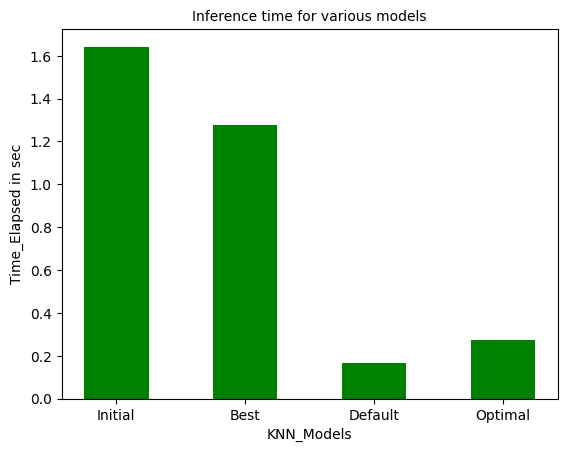

In [12]:
times = [elapsed_time_initial,elapsed_time_best,elapsed_time_default, elapsed_time_optimal]
labels_time = ['Initial', 'Best', 'Default', 'Optimal']
plt.bar(labels_time, times, color='green', width=0.5)
plt.xlabel('KNN_Models', fontsize=10)
plt.ylabel('Time_Elapsed in sec', fontsize=10)
plt.title('Inference time for various models', fontsize=10)
plt.show()


### Inference time vs data set size

#### For Initial Model

In [13]:
test_data_size = 0.05
initial_model_times = []
data_split = []
while test_data_size <= 0.8:
  data_split.append(test_data_size)
  start_time = time.time()
  knn = KNNModel()
  knn.set_k(5)
  knn.set_encoder('ResNet')
  knn.set_distance_metric('euclidean')
  X_train, X_test, y_train, y_test = train_test_split(knn.encoder['X'], knn.encoder['Y'], test_size=test_data_size, random_state=42)
  knn.fit(X_train, y_train)
  metrics = knn.evaluate(X_test, y_test)
  initial_model_times.append(time.time() - start_time)
  test_data_size += 0.05


#### For Best Model

In [14]:
test_data_size = 0.05
best_model_times = []
data_split = []
while test_data_size <= 0.8:
  data_split.append(test_data_size)
  start_time = time.time()
  knn = KNNModel()
  knn.set_k(best_knn_metrics[1])
  knn.set_encoder(best_knn_metrics[2])
  knn.set_distance_metric(best_knn_metrics[3])
  X_train, X_test, y_train, y_test = train_test_split(knn.encoder['X'], knn.encoder['Y'], test_size=test_data_size, random_state=42)
  knn.fit(X_train, y_train)
  metrics = knn.evaluate(X_test, y_test)
  best_model_times.append(time.time() - start_time)
  test_data_size += 0.05

#### For Optimised Model

In [15]:
test_data_size = 0.05
optimised_model_times = []
data_split = []
while test_data_size <= 0.8:
  data_split.append(test_data_size)
  start_time = time.time()
  knn = Optimised_KNNModel()
  knn.set_k(5)
  knn.set_encoder('ResNet')
  knn.set_distance_metric('euclidean')
  X_train, X_test, Y_train, Y_test = train_test_split(knn.encoder['X'], knn.encoder['Y'], test_size=0.2, random_state=42)
  knn.fit(X_train, Y_train)
  metrics = knn.evaluate(X_test, Y_test)
  optimised_model_times.append(time.time() - start_time)
  test_data_size += 0.05

#### For Default KNN Model

In [16]:
test_data_size = 0.05
default_model_times = []
data_split = []
while test_data_size <= 0.8:
  data_split.append(test_data_size)
  start_time = time.time()
  X = []
  Y = []
  for row in data:
    X.append(row[1].flatten())
    Y.append(row[3])

  # Split data into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

  # Create and train KNN classifier
  k = 5  # Number of neighbors
  knn_classifier = KNeighborsClassifier(n_neighbors=k)
  knn_classifier.fit(X_train, y_train)

  # Make predictions and evaluate
  y_pred = knn_classifier.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='micro', zero_division=0)
  recall = recall_score(y_test, y_pred, average='micro', zero_division=0)
  f1 = f1_score(y_test, y_pred, average='micro', zero_division=0)
  default_model_times.append(time.time() - start_time)
  test_data_size += 0.05

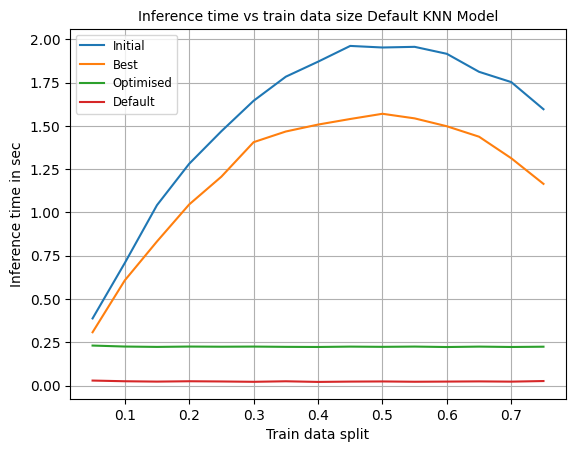

In [17]:
plt.plot(data_split, initial_model_times, label='Initial')
plt.plot(data_split, best_model_times, label='Best')
plt.plot(data_split, optimised_model_times, label='Optimised')
plt.plot(data_split, default_model_times, label='Default')
plt.xlabel('Train data split', fontsize=10)
plt.ylabel('Inference time in sec', fontsize=10)
plt.title('Inference time vs train data size Default KNN Model', fontsize=10)
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
plt.show()

## Part-2: Decision Tree Classifier

#### Reading the Data

In [18]:
data = pd.read_csv('advertisement.csv')
X = data.drop(['labels'], axis=1)
Y = data['labels']

features = ['gender', 'education', 'married', 'city', 'occupation', 'most bought item']
X = pd.get_dummies(X, columns=features)
X, Y = shuffle(X, Y, random_state=0)

#### Task-1:  Decision Tree Classifier Class with the Powerset Formulation

In [19]:
class PowersetDecisionTreeClassifier:
  def __init__(self, max_depth=None, max_features=None, criterion='entropy'):
    self.max_depth = max_depth
    self.max_features = max_features
    self.criterion = criterion
    self.features = features
    self.dtree = DecisionTreeClassifier(max_depth=self.max_depth,
                                        max_features=self.max_features, 
                                        criterion=self.criterion)
    self.X = None
    self.Y = None
    self.map = []
    
  def _powerset(self, iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
  
  def fit(self, X, Y):
    self.X = X
    self.Y = []
    unique_labels = {label for elem in Y for label in elem.split(" ")}
    ps = self._powerset(unique_labels)
    for p in ps:
      self.map.append(sorted(p))
    for y in Y:
      self.Y.append(self.map.index(sorted(y.split(' '))))
    self.Y = np.array(self.Y)
    self.dtree.fit(self.X, self.Y)
    
  def predict(self, X_test):
    y_pred = list(self.dtree.predict(X_test))
    for i, y in enumerate(y_pred):
      y_pred[i] = ' '.join(self.map[y])
    return y_pred

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# Create and train the PowersetDecisionTreeClassifier
powerset_tree = PowersetDecisionTreeClassifier(max_depth=3, max_features=10, criterion='entropy')
powerset_tree.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = powerset_tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro', zero_division=0)
recall = recall_score(y_test, y_pred, average='micro', zero_division=0)
f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
conf_mat = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy*100)
print("Precision:", precision*100)
print("Recall:", recall*100)
print("F1 Score Micro:", f1_micro*100)
print("F1 Score Macro:", f1_macro*100)
print("Confusion Matrix:\n", *conf_mat, sep='\n')


Accuracy: 2.5
Precision: 2.5
Recall: 2.5
F1 Score Micro: 2.5000000000000004
F1 Score Macro: 0.03528457005751385
Confusion Matrix:

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0

#### Hyperparameter Tuning

In [21]:

criterion = ['gini', 'entropy']
max_depth = [3,5,10,20,30]
max_features = [3,5,7,9,11]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

parameters = []
output_table = []


for max_depth_val in max_depth:
  for max_features_val in max_features:
    for criterion_val in criterion:
      powerset_tree = PowersetDecisionTreeClassifier(max_depth=max_depth_val, 
                                                     max_features=max_features_val, 
                                                     criterion=criterion_val)
      powerset_tree.fit(X_train, y_train)
      y_pred = powerset_tree.predict(X_test)
      accuracy = accuracy_score(y_test, y_pred)
      precision = precision_score(y_test, y_pred, average='micro', zero_division=0)
      recall = recall_score(y_test, y_pred, average='micro', zero_division=0)
      f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
      f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
      conf_mat = confusion_matrix(y_test, y_pred)
      # print("Confusion Matrix:\n", conf_mat)
      # print('--'*20)
      output_table.append([criterion_val, max_depth_val, max_features_val, accuracy, precision, recall, f1_micro, f1_macro])
      heapq.heappush(parameters, (f1_micro, criterion_val, max_depth_val, max_features_val))

df = pd.DataFrame(output_table, columns = ['criteria', 'max_depth', 'max_features', 'accuracy_score', 'f1_micro', 'f1_macro', 'precision_score', 'recall_score'])
top3 = (heapq.nlargest(3, parameters))
print('top 3 triplets:')
for triplet in top3:
  print(triplet)
print('--'*20)
ptree_best_metrics = heapq.nlargest(1, parameters)[0]
print('best f1 micro score triplet: ', ptree_best_metrics)
df = df.set_index('criteria')
df

top 3 triplets:
(0.04, 'entropy', 20, 3)
(0.04, 'entropy', 10, 3)
(0.035, 'gini', 30, 7)
----------------------------------------
best f1 micro score triplet:  (0.04, 'entropy', 20, 3)


,max_depth,max_features,accuracy_score,f1_micro,f1_macro,precision_score,recall_score
criteria,,,,,,,
gini,3,3,0.025,0.025,0.025,0.025,0.002134
entropy,3,3,0.020,0.020,0.020,0.020,0.000306
gini,3,5,0.030,0.030,0.030,0.030,0.002133
entropy,3,5,0.030,0.030,0.030,0.030,0.001377
gini,3,7,0.025,0.025,0.025,0.025,0.000346
entropy,3,7,0.025,0.025,0.025,0.025,0.000346
gini,3,9,0.025,0.025,0.025,0.025,0.000346
entropy,3,9,0.025,0.025,0.025,0.025,0.000355
gini,3,11,0.025,0.025,0.025,0.025,0.000356


#### Task-2 Decision Tree Classifier Class with the MultiOutput Formulation

In [22]:
class MultiOutputDecisionTreeClassifier:
  def __init__(self, max_depth=None, max_features=None, criterion='entropy'):
    self.max_depth = max_depth
    self.max_features = max_features
    self.criterion = criterion
    self.features = features
    self.dtree = DecisionTreeClassifier(max_depth=self.max_depth,
                                        max_features=self.max_features, 
                                        criterion=self.criterion)
    self.X = None
    self.Y = None
    self.map = []
  
  def fit(self, X, Y):
    self.X = X
    self.Y = []
    unique_labels = sorted({label for elem in Y for label in elem.split(" ")})
    self.map = unique_labels
    for y in Y:
      self.Y.append([1 if label in y.split(' ') else 0 for label in unique_labels])
    self.dtree.fit(self.X, self.Y)
    
  def predict(self, X_test):
    y_pred = list(self.dtree.predict(X_test))
    # print(y_pred)
    for i, y in enumerate(y_pred):
      tmp = ''
      for j, label in enumerate(y):
        if label == 1:
          tmp += self.map[j] + ' '
      y_pred[i] = tmp[:-1]
    # print(y_pred)
    return y_pred

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# Create and train the MultiOutputDecisionTreeClassifier
multiout_tree = MultiOutputDecisionTreeClassifier(max_depth=10, max_features=10, criterion='entropy')
multiout_tree.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = multiout_tree.predict(X_test)
# print(y_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro', zero_division=0)
recall = recall_score(y_test, y_pred, average='micro', zero_division=0)
f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
conf_mat = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy*100)
print("Precision:", precision*100)
print("Recall:", recall*100)
print("F1 Score Micro:", f1_micro*100)
print("F1 Score Macro:", f1_macro*100)
print("Confusion Matrix:\n", conf_mat)


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score Micro: 1.0
F1 Score Macro: 0.3160919540229885
Confusion Matrix:
 [[0 0 0 ... 0 0 0]
 [6 0 0 ... 0 0 0]
 [3 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]]


#### Hyperparameter Tuning

In [24]:

criterion = ['gini', 'entropy']
max_depth = [3,5,10,20,30]
max_features = [3,5,7,9,11]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

parameters = []
output_table = []

for max_depth_val in max_depth:
  for max_features_val in max_features:
    for criterion_val in criterion:
      powerset_tree = MultiOutputDecisionTreeClassifier(max_depth=max_depth_val, 
                                                        max_features=max_features_val, 
                                                        criterion=criterion_val)
      powerset_tree.fit(X_train, y_train)
      y_pred = powerset_tree.predict(X_test)
      accuracy = accuracy_score(y_test, y_pred)
      precision = precision_score(y_test, y_pred, average='micro', zero_division=0)
      recall = recall_score(y_test, y_pred, average='micro', zero_division=0)
      f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
      f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
      conf_mat = confusion_matrix(y_test, y_pred)
      # print("Confusion Matrix:\n", conf_mat)
      # print('--'*20)
      output_table.append([criterion_val, max_depth_val, max_features_val, accuracy, precision, recall, f1_micro, f1_macro])
      heapq.heappush(parameters, (f1_micro*100, criterion_val, max_depth_val, max_features_val))

df = pd.DataFrame(output_table, columns = ['criteria', 'max_depth', 'max_features', 'accuracy_score', 'f1_micro', 'f1_macro', 'precision_score', 'recall_score'])
top3 = (heapq.nlargest(3, parameters))
print('top 3 triplets:')
for triplet in top3:
  print(triplet)
print('--'*20)
mtree_best_metrics = heapq.nlargest(1, parameters)[0]
print('best f1 micro score triplet: ', mtree_best_metrics)
df = df.set_index('criteria')
df

top 3 triplets:
(3.0, 'entropy', 3, 9)
(2.5000000000000004, 'gini', 10, 11)
(2.5000000000000004, 'entropy', 5, 11)
----------------------------------------
best f1 micro score triplet:  (3.0, 'entropy', 3, 9)


,max_depth,max_features,accuracy_score,f1_micro,f1_macro,precision_score,recall_score
criteria,,,,,,,
gini,3,3,0.000,0.000,0.000,0.000,0.000000
entropy,3,3,0.000,0.000,0.000,0.000,0.000000
gini,3,5,0.000,0.000,0.000,0.000,0.000000
entropy,3,5,0.000,0.000,0.000,0.000,0.000000
gini,3,7,0.000,0.000,0.000,0.000,0.000000
entropy,3,7,0.020,0.020,0.020,0.020,0.003023
gini,3,9,0.005,0.005,0.005,0.005,0.001237
entropy,3,9,0.030,0.030,0.030,0.030,0.006047
gini,3,11,0.000,0.000,0.000,0.000,0.000000


#### K Fold Validation for PowerSet Decision Tree Classifier

#### Using default sklearn metrics kFold validation

In [25]:
k_folds = 10
kf = KFold(n_splits=k_folds, shuffle=True, random_state=0)

# Initialize list to store validation scores
validation_scores = []

# Perform K-Fold cross-validation
for train_index, test_index in kf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = Y[train_index], Y[test_index]
  
  # Create and train the PowersetDecisionTreeClassifier
  powerset_tree = PowersetDecisionTreeClassifier(max_depth=ptree_best_metrics[2], 
                                                 max_features=ptree_best_metrics[3], 
                                                 criterion=ptree_best_metrics[1])
  powerset_tree.fit(X_train, y_train)
  
  # Make predictions
  y_pred = powerset_tree.predict(X_test)
  
  # Calculate accuracy for this fold
  accuracy = accuracy_score(y_test, y_pred)
  
  # Append accuracy to the validation_scores list
  validation_scores.append(accuracy)

# Print the validation scores for each fold
print(validation_scores)

# Calculate the average validation score
average_validation_score = np.mean(validation_scores)
print(f"Average Validation Score = {average_validation_score * 100}")


[0.02, 0.04, 0.03, 0.02, 0.0, 0.01, 0.04, 0.01, 0.01, 0.01]
Average Validation Score = 1.9000000000000004


#### Using own method

In [26]:

k_fold = 10
accuracies = []

X_parts = np.array_split(X, k_fold)
Y_parts = np.array_split(Y, k_fold)


# Perform K-Fold cross-validation
for i in range(k_fold):
  X_train, X_test = np.concatenate(X_parts[:i] + X_parts[i+1:]), X_parts[i]
  y_train, y_test = np.concatenate(Y_parts[:i] + Y_parts[i+1:]), Y_parts[i]

  # Create and train the PowersetDecisionTreeClassifier
  powerset_tree = PowersetDecisionTreeClassifier(max_depth=ptree_best_metrics[2], 
                                                 max_features=ptree_best_metrics[3], 
                                                 criterion=ptree_best_metrics[1])
  powerset_tree.fit(X_train, y_train)

  # Make predictions
  y_pred = powerset_tree.predict(X_test)

  # Calculate accuracy for this fold
  accuracy = accuracy_score(y_test, y_pred)
  accuracies.append(accuracy*100)

# Calculate average and standard deviation of accuracy
avg_accuracy = np.mean(accuracies)

print("Average accuracy:", avg_accuracy)

Average accuracy: 1.3


/Users/chnaveen/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/chnaveen/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/chnaveen/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/chnaveen/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/chnaveen/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/chnaveen/Library/Python/3.9/lib/p

#### K Fold Validation for MultiOutput Decision Tree Classifier

#### Using own method

In [27]:
k_fold = 10
accuracies = []

X_parts = np.array_split(X, k_fold)
Y_parts = np.array_split(Y, k_fold)

# Perform K-Fold cross-validation
for i in range(k_fold):
  X_train, X_test = np.concatenate(X_parts[:i] + X_parts[i+1:]), X_parts[i]
  y_train, y_test = np.concatenate(Y_parts[:i] + Y_parts[i+1:]), Y_parts[i]

  # Create and train the PowersetDecisionTreeClassifier
  multiout_tree = MultiOutputDecisionTreeClassifier(max_depth=mtree_best_metrics[2], 
                                                    max_features=mtree_best_metrics[3], 
                                                    criterion=mtree_best_metrics[1])
  multiout_tree.fit(X_train, y_train)

  # Make predictions
  y_pred = multiout_tree.predict(X_test)

  # Calculate accuracy for this fold
  accuracy = accuracy_score(y_test, y_pred)
  accuracies.append(accuracy*100)

# Calculate average and standard deviation of accuracy
# print(accuracies)
avg_accuracy = np.mean(accuracies)

print("Average accuracy:", avg_accuracy)

Average accuracy: 0.2


/Users/chnaveen/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/chnaveen/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/chnaveen/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/chnaveen/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/chnaveen/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/chnaveen/Library/Python/3.9/lib/p